# **Spin** calculation

IDEA:
- take in consideration only the ball for each frame
- draw a lot of points on the ball
- take the motion of these points between consecutive frames (optical flow)
- from this motion we extract the direction of the rotation and so the axis of rotation

In [1454]:
from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from matplotlib import pyplot as plt

In [1455]:
VIDEO_NUMBER = "3"
PROJECT_ROOT = Path().resolve().parent.parent
INPUT_VIDEO_PATH = str(
    PROJECT_ROOT
    / "data"
    / f"recording_{VIDEO_NUMBER}"
    / f"Recording_{VIDEO_NUMBER}.mp4"
)
INPUT_CSV_PATH = str(
    PROJECT_ROOT
    / "data"
    / "auxiliary_data"
    / "circle_positions"
    / f"Adjusted_positions_new_{VIDEO_NUMBER}.csv"
)

In [1456]:
# Load video and CSV
cap = cv2.VideoCapture(INPUT_VIDEO_PATH)
if not cap.isOpened():
    raise IOError("Error: Could not open video.")
df = pd.read_csv(INPUT_CSV_PATH)
if df.empty:
    raise ValueError("Error: The CSV file is empty.")

Selecting a frame

In [1457]:
# Select frame and next frame
frame_number = 90
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
ret, frame1 = cap.read()
if not ret:
    raise IOError(f"Failed to read frame {frame_number}.")
ret, frame2 = cap.read()
if not ret:
    raise IOError(f"Failed to read frame {frame_number + 1}.")

In [1458]:
# Extract ball center and radius
df_row = df.iloc[frame_number]
ball_center = np.array([int(df_row["x"]), int(df_row["y"])])
ball_radius = int(df_row["radius"])

# Compute ROI bounds
offset = 2
x_min = max(ball_center[0] - ball_radius - offset, 0)
x_max = min(ball_center[0] + ball_radius + offset, frame1.shape[1])
y_min = max(ball_center[1] - ball_radius - offset, 0)
y_max = min(ball_center[1] + ball_radius + offset, frame1.shape[0])

# Crop ROI and convert to grayscale
roi1 = frame1[y_min:y_max, x_min:x_max]
roi2 = frame2[y_min:y_max, x_min:x_max]
gray1 = cv2.cvtColor(roi1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(roi2, cv2.COLOR_BGR2GRAY)

# Compute center in ROI coordinates
center_roi = np.array([ball_center[0] - x_min, ball_center[1] - y_min])

In [1459]:
# Generate 100 random points inside the circular ROI
h, w = gray1.shape
points = []
while len(points) < 100:
    x, y = np.random.randint(0, w), np.random.randint(0, h)
    if (x - center_roi[0]) ** 2 + (y - center_roi[1]) ** 2 <= (ball_radius * 0.8) ** 2:
        points.append([x, y])
p0 = np.array(points, dtype=np.float32).reshape(-1, 1, 2)

# Track points to next frame
p1, status, _ = cv2.calcOpticalFlowPyrLK(
    gray1,
    gray2,
    p0,
    None,
    winSize=(15, 15),
    maxLevel=2,
    criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03),
)

In [1460]:
# Lift 2D points to 3D on sphere surface
old3d = []
new3d = []
for old_pt, new_pt, s in zip(p0.reshape(-1, 2), p1.reshape(-1, 2), status.reshape(-1)):
    if s == 1:
        ox, oy = old_pt - center_roi
        nx, ny = new_pt - center_roi
        oz = np.sqrt(max(ball_radius**2 - ox**2 - oy**2, 0))
        nz = np.sqrt(max(ball_radius**2 - nx**2 - ny**2, 0))
        old3d.append([ox, oy, oz])
        new3d.append([nx, ny, nz])
old3d = np.array(old3d)
new3d = np.array(new3d)

In [1461]:
# Kabsch algorithm to find rotation matrix R
# subtract centroids (but both centered at origin already)
H = old3d.T @ new3d
U, S, Vt = np.linalg.svd(H)
R = Vt.T @ U.T
# ensure right-handed
if np.linalg.det(R) < 0:
    Vt[-1, :] *= -1
    R = Vt.T @ U.T

# extract axis-angle from R
theta = np.arccos((np.trace(R) - 1) / 2)
axis = np.array([R[2, 1] - R[1, 2], R[0, 2] - R[2, 0], R[1, 0] - R[0, 1]])
axis = axis / (2 * np.sin(theta))
axis = axis / np.linalg.norm(axis)

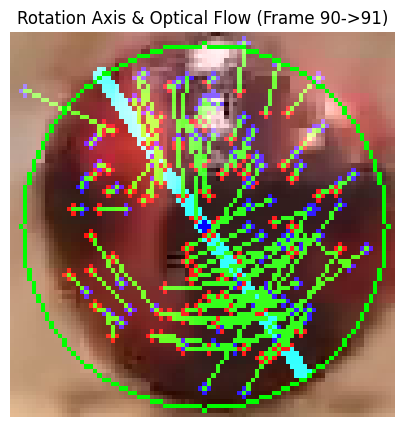

In [1462]:
# prepare visualization overlay
mask = np.zeros_like(roi1)
# project axis to image plane (ignore z)
a2d = axis[:2]
a2d = a2d / np.linalg.norm(a2d)
# draw axis line through center_roi
length = ball_radius
pt1 = (center_roi + a2d * length).astype(int)
pt2 = (center_roi - a2d * length).astype(int)
cv2.line(mask, tuple(pt1), tuple(pt2), (255, 255, 0), 2)

# draw tracked vectors
for (new_pt,), (old_pt,), s in zip(p1, p0, status):
    if s[0] == 1:
        c = tuple(old_pt.astype(int))
        a = tuple(new_pt.astype(int))
        cv2.circle(mask, c, 1, (0, 0, 255), -1)
        cv2.circle(mask, a, 1, (255, 0, 0), -1)
        cv2.line(mask, c, a, (0, 255, 0), 1)

# overlay and display
output_roi = cv2.addWeighted(roi1, 1, mask, 1, 0)
output_rgb = cv2.cvtColor(output_roi, cv2.COLOR_BGR2RGB)

# show the ball center
cv2.circle(output_rgb, tuple(center_roi), 1, (0, 0, 255), -1)
# show the ball radius
cv2.circle(output_rgb, tuple(center_roi), ball_radius, (0, 255, 0), 1)
plt.figure(figsize=(5, 5))
plt.imshow(output_rgb)
plt.axis("off")
plt.title(f"Rotation Axis & Optical Flow (Frame {frame_number}->{frame_number + 1})")
plt.show()